# Imports

In [1]:
import pathlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants

In [3]:
PROJECT_DIR = pathlib.Path('~/work').expanduser()
DATA_DIR = PROJECT_DIR / 'data'

# Data

In [4]:
data_births = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'daily-total-female-births-CA.csv',
    index_col=['date'],
    parse_dates=['date']
)
data_births.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


# Autoregressive Models

In [12]:
import pmdarima as pm

model = pm.ARIMA(order=(1, 1, 0))
model.fit(data_births['births'])

ARIMA(order=(1, 1, 0))

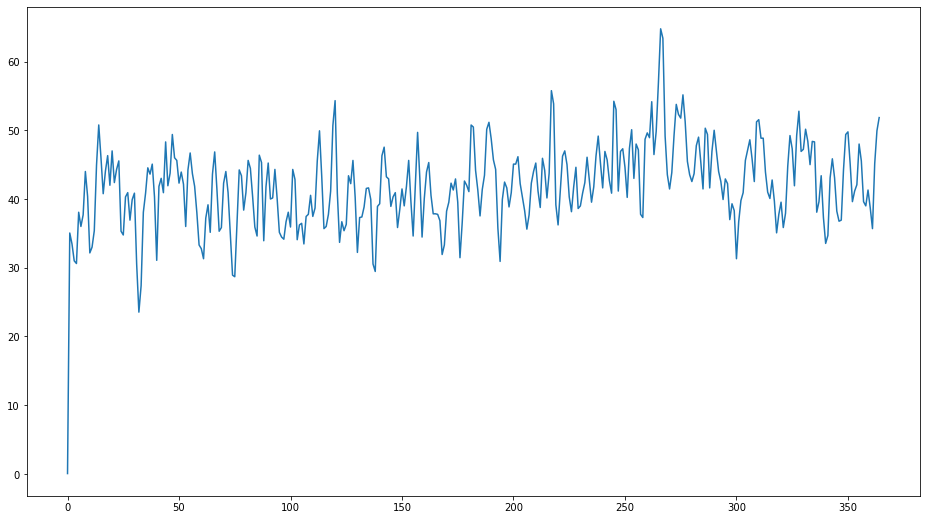

In [14]:
plt.plot(model.predict_in_sample())

In [11]:
results_AR.fittedvalues

date
1959-01-02    0.048236
1959-01-03    1.456118
1959-01-04    0.994250
1959-01-05   -0.391353
1959-01-06   -5.933765
                ...   
1959-12-27    4.689191
1959-12-28   -1.315088
1959-12-29   -6.857500
1959-12-30    1.917985
1959-12-31   -3.162559
Length: 364, dtype: float64

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be use

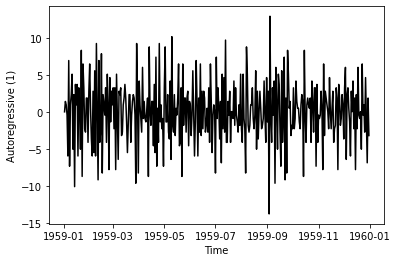

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
model = ARIMA(data_births['births'], order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(results_AR.fittedvalues, color='black')
plt.ylabel('Autoregressive (1)')
plt.xlabel('Time')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

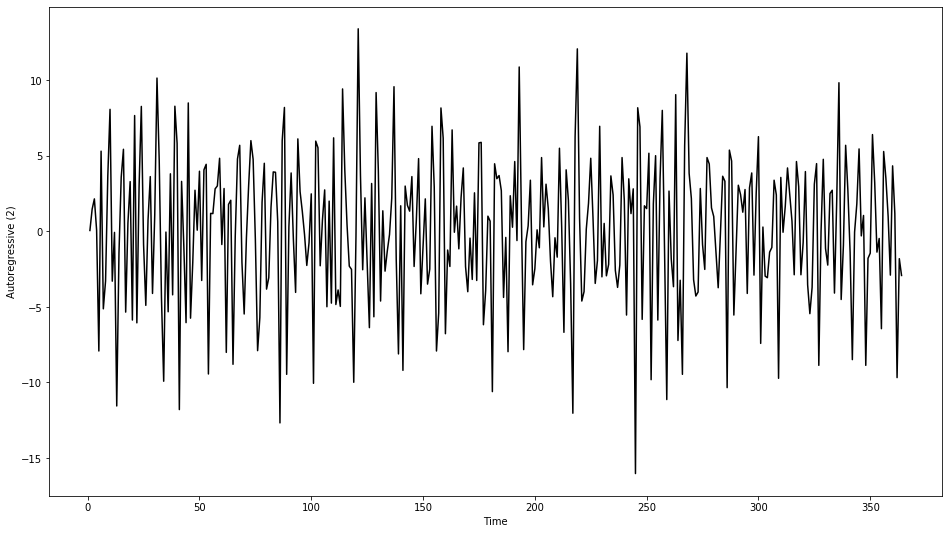

In [17]:
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
model = ARIMA(df['births'], order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(results_AR.fittedvalues, color='black')
plt.ylabel('Autoregressive (2)')
plt.xlabel('Time')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

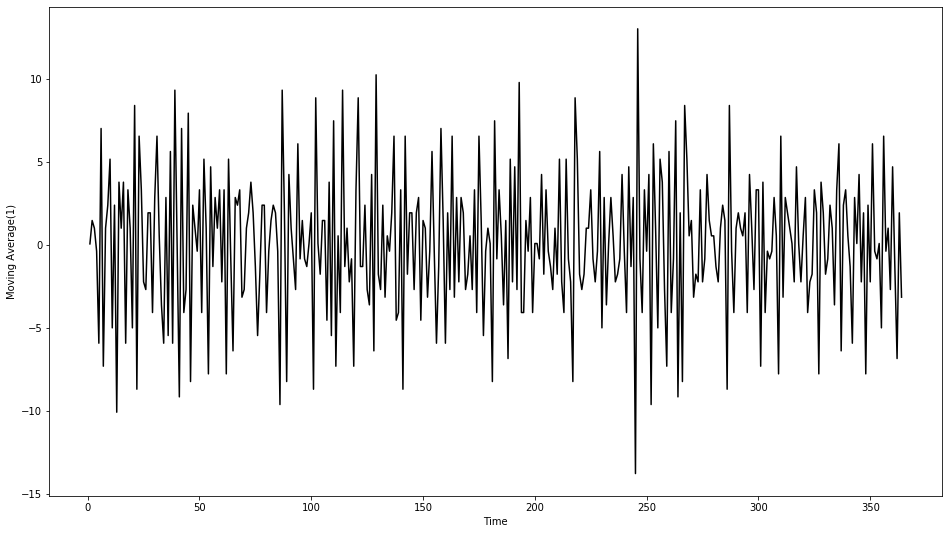

In [18]:
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
model = ARIMA(df['births'], order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(results_AR.fittedvalues, color='black')
plt.ylabel('Moving Average(1)')
plt.xlabel('Time')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

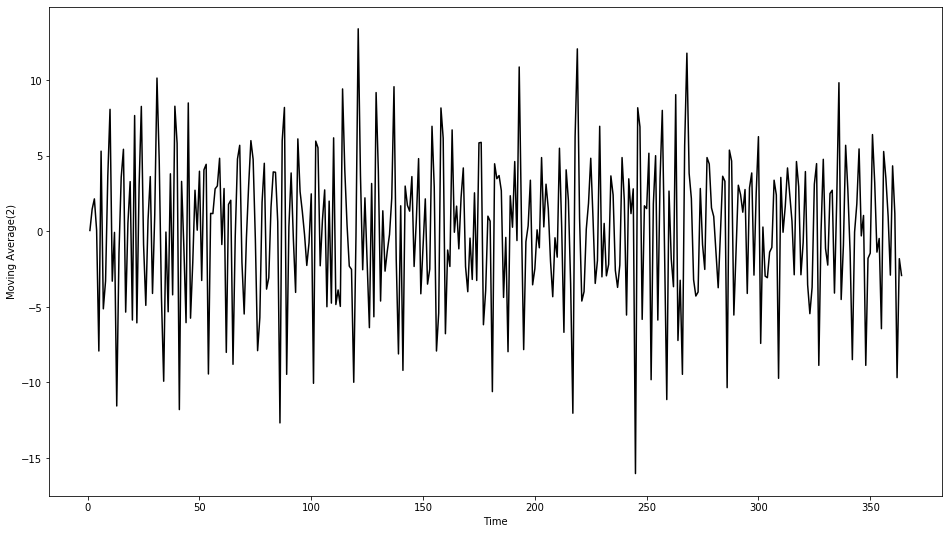

In [19]:
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
model = ARIMA(df['births'], order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(results_AR.fittedvalues, color='black')
plt.ylabel('Moving Average(2)')
plt.xlabel('Time')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()